In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import numpy as np


In [17]:
class ODEsolver(Sequential):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.loss_tracker = keras.metrics.Mean(name = 'my_loss')

  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self, data):
    batch_size = tf.shape(data)[0]
    x = tf.random.uniform((batch_size, 1), minval = -5, maxval = 5)
    x_o = tf.zeros((batch_size, 1))

    with tf.GradientTape() as tape:
      with tf.GradientTape() as g:
        g.watch(x)
        with tf.GradientTape(persistent = True) as gg:
          gg.watch(x)
          gg.watch(x_o)
          y_pred = self(x, training = True)
        dy_dx = gg.gradient(y_pred, x)
        dy_o = gg.gradient(y_pred, x_o)
      d2y_dx2 = g.gradient(dy_dx, x)
      y_o = self(x_o, training = True)
      eq = d2y_dx2 + y_pred
      ic1 = y_o - 1
      ic2 = dy_o + 0.5
      loss = keras.losses.mean_squared_error(0., eq) + keras.losses.mean_squared_error(0., ic1) + keras.losses.mean_squared_error(0., ic2)      
             
          

    grads = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

    self.loss_tracker.update_state(loss)

    return {'my_loss': self.loss_tracker.result()}

  

In [18]:
model = ODEsolver()
model.add(Dense(10, activation = 'tanh', input_shape = (1,)))
model.add(Dense(8, activation = 'tanh'))
model.add(Dense(4, activation = 'tanh'))
model.add(Dense(1, activation = 'linear'))

In [19]:
model.summary()

Model: "od_esolver_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                20        
                                                                 
 dense_9 (Dense)             (None, 8)                 88        
                                                                 
 dense_10 (Dense)            (None, 4)                 36        
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                                 
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer = Adam(), metrics = ['my_loss'])

In [21]:
x = tf.linspace(-5, 5, 1000)
history = model.fit(x, epochs = 1000, verbose = 1)

Epoch 1/1000
32/32 [==============================] - 1s 2ms/step - my_loss: 0.8464
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - my_loss: 0.4726
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - my_loss: 0.2828
Epoch 4/1000
32/32 [==============================] - 0s 2ms/step - my_loss: 0.2156
Epoch 5/1000
32/32 [==============================] - 0s 2ms/step - my_loss: 0.1954
Epoch 6/1000
32/32 [==============================] - 0s 2ms/step - my_loss: 0.1856
Epoch 7/1000
32/32 [==============================] - 0s 2ms/step - my_loss: 0.1658
Epoch 8/1000
32/32 [==============================] - 0s 2ms/step - my_loss: 0.1719
Epoch 9/1000
32/32 [==============================] - 0s 2ms/step - my_loss: 0.1563
Epoch 10/1000
32/32 [==============================] - 0s 2ms/step - my_loss: 0.1545
Epoch 11/1000
32/32 [==============================] - 0s 2ms/step - my_loss: 0.1434
Epoch 12/1000
32/32 [==============================] - 0s 2ms/step - my_lo

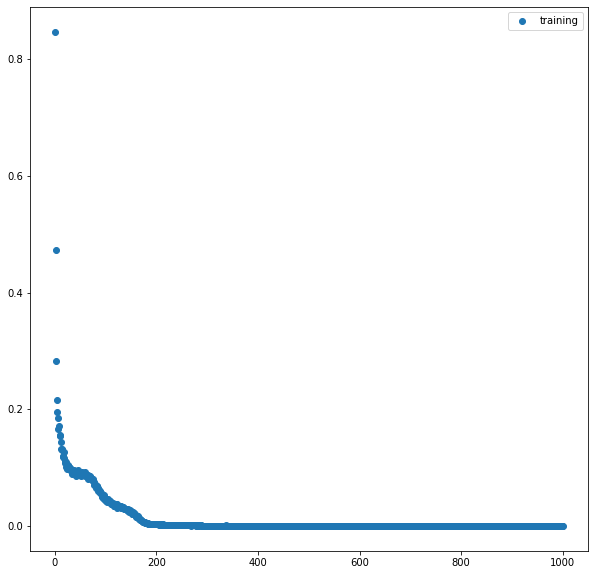

In [22]:
history_dict = history.history
loss_values = history_dict['my_loss']


fig = plt.figure(figsize=(10,10))
epoch = range(1,len(loss_values)+1)
plt.plot(epoch,loss_values, 'o',label='training')
plt.legend()
plt.show()

In [23]:
def solution_2(x):
  return np.cos(x)



32/32 [==============================] - 0s 1ms/step


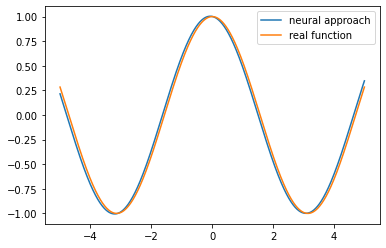

In [25]:
x_test = tf.linspace(-5, 5, 1000)
a = model.predict(x_test)
plt.plot(x_test, a, label = 'neural approach')
plt.plot(x_test, solution_2(x_test), label = 'real function')
plt.legend()
plt.show()